In [8]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
#import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math
import dill as pickle



workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.utils import get_aligned_ids
from mcmodels.core import VoxelModelCache
from mcmodels.connectivity.creation import get_connectivity_matrices3
from mcmodels.core.connectivity_data import get_connectivity_data
#from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures, get_leaves_ontologicalorder, get_indices_2ormore, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3
from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter
from mcmodels.models.expectedloss.crossvalidation import get_loss_surface_cv_spline
from mcmodels.models.expectedloss.crossvalidation import get_embedding_cv
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss, Crossval
from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists

def get_row_col_names(connectivity_data, target_ordering):
    
    rnames = np.asarray([ia_map[target_ordering[i]] for i in range(len(target_ordering))])
    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions                               
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)    
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    colids = np.concatenate([ipsi_target_regions, contra_target_regions])[reorder]
    cnames = np.asarray([ia_map[colids[i]] for i in range(len(colids))])
    ccomb = np.vstack([np.concatenate([np.repeat('ipsi',connectivity_data.ipsi_target_regions.shape[0]),
                                       np.repeat('contra',connectivity_data.contra_target_regions.shape)]), cnames])
    ccomb = np.asarray(ccomb)
    tuples2 = list(zip(*ccomb))
    cnam_multi = pd.MultiIndex.from_tuples(tuples2, names=['first', 'second'])
    return(cnam_multi, rnames)

def fix_pdcsv(csv):
    
    #wt_conn = pd.read_csv('/Users/samsonkoelle/wt_leafsmooth_leafsurface_sumtarget.csv',  header=[0,1])
    csv_rownames = np.asarray(csv.iloc[:,0])
    csv = csv.iloc[:,1:]
    csv.index = csv_rownames
    return(csv)

def fill_df_na(data, indices):
    
    for i in range(indices.shape[0]):
        data.iloc[indices[i,0],indices[i,1]] = np.nan
        
    return(data)

from mcmodels.core import Mask

def get_regional_sizes(cache,sid,hemisphere_id):
    
    mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=hemisphere_id)
    size = mask.coordinates.shape[0]
    
    return(size)

def get_aligned_ids(st,list1,list2):
    output = np.empty(len(list1), dtype = int)
    for i in range(len(list1)):
        output[ i] = np.intersect1d(st.ancestor_ids([list1[i]]), list2)[0]
    return(output)

def get_combined_sources(data, list1, list2, sizes):
    ids = np.where(data.sum(axis = 1) > 0)[0]
    ool_s = get_aligned_ids(st,list1,list2)
    list2 = np.asarray(list2)
    nsum = list2.shape[0]
    data_sum = np.zeros((nsum, data.shape[1]))
    ids = np.where(data.sum(axis = 1) > 0)[0]
    for s in range(nsum):
        inds = np.where(ool_s[ids] == list2[s])[0]
        #print(sizes[inds])
        data_sum[s] = sizes[ids][inds] @ data[ids][inds] / np.sum(sizes[ids][inds])
    return(data_sum)

def get_combined_targets(data, list1, list2, sizes):
    '''
    this function sums connectivity of targets in list 1 that have the same metastructure in list 2
    '''
    ool_s = get_aligned_ids(st,list1,list2)
    list2 = np.asarray(list2)
    nsum = list2.shape[0]
    data_sum = np.zeros((data.shape[0], nsum)) 
    for s in range(nsum):
        inds = np.where(ool_s == list2[s])[0]
        #print(inds, data.shape)
        data_sum[:,s] = data[:,inds].sum(axis = 1)#data[:,inds].transpose()#sizes[inds] @ data[:,inds].transpose() / np.sum(sizes[inds])
        #print(np.nanmax(data_sum[:,s]))

    return(data_sum)

def comb_targs(csv):
    
    conn_leafleaf = pd.read_csv(csv,  header=[0,1])
    conn_leafleaf = fix_pdcsv(conn_leafleaf)    
    data = conn_leafleaf
    data_sourcecomb = np.asarray(data)
    contra_subset_names = targets[:contra_min][:,1]
    contra_subset_ids = np.asarray([ai_map[contra_subset_names[i]] for i in range(len(contra_subset_names))])
    contra_targets_summary_ordered = np.asarray([i for i in ontological_order if i in contra_targets_summary_unordered])
    ipsi_targets_summary_ordered = np.asarray([i for i in ontological_order if i in ipsi_targets_summary_unordered])
    ia_map = {value: key for key, value in ai_map.items()}
    #get combined targets
    list1 = np.asarray([ai_map[targets[:,1][i]] for i in range(contra_min)])
    data_ipsicomb = get_combined_targets(data_sourcecomb[:,:(contra_min)], list1, np.asarray(ipsi_targets_summary_ordered), sizes_ipsi)
    list1 = np.asarray([ai_map[targets[:,1][i]] for i in range(contra_min, targets.shape[0])])
    data_contracomb = get_combined_targets(data_sourcecomb[:,(contra_min):], list1, np.asarray(contra_targets_summary_ordered), sizes_contra)
    data_combined = np.hstack([data_ipsicomb,data_contracomb])
    ncontra = contra_targets_summary_ordered.shape[0]
    nipsi = ipsi_targets_summary_ordered.shape[0]
    ctso_names = [ia_map[contra_targets_summary_ordered[i]] for i in range(len(contra_targets_summary_ordered))]
    itso_names = [ia_map[ipsi_targets_summary_ordered[i]] for i in range(len(ipsi_targets_summary_ordered))]
    bigs = np.concatenate([np.repeat('ipsi', nipsi),np.repeat('contra', ncontra)])
    smalls = np.concatenate([itso_names, ctso_names])
    arrays = np.vstack([bigs,smalls]  )
    tuples = list(zip(*arrays))
    columns = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])
    output = pd.DataFrame(data_combined,index = data.index, columns=columns)
    return(output)

def comb_targs_sumsum(csv):
    
    conn_leafleaf = pd.read_csv(csv,  header=[0,1])
    conn_leafleaf = fix_pdcsv(conn_leafleaf)    
    data = conn_leafleaf
    list1 = [ai_map[data.index[i]] for i in range(data.shape[0])]
    list2 = ontological_order#[ai_map[wt_conn.columns[i][1]] for i in range(321)]
    data_sourcecomb = np.asarray(get_combined_sources(np.asarray(data), list1, list2, sizes))

    #data_sourcecomb = np.asarray(data)
    contra_subset_names = targets[:contra_min][:,1]
    contra_subset_ids = np.asarray([ai_map[contra_subset_names[i]] for i in range(len(contra_subset_names))])
    contra_targets_summary_ordered = np.asarray([i for i in ontological_order if i in contra_targets_summary_unordered])
    ipsi_targets_summary_ordered = np.asarray([i for i in ontological_order if i in ipsi_targets_summary_unordered])
    ia_map = {value: key for key, value in ai_map.items()}
    #get combined targets
    list1 = np.asarray([ai_map[targets[:,1][i]] for i in range(contra_min)])
    data_ipsicomb = get_combined_targets(data_sourcecomb[:,:(contra_min)], list1, np.asarray(ipsi_targets_summary_ordered), sizes_ipsi)
    list1 = np.asarray([ai_map[targets[:,1][i]] for i in range(contra_min, targets.shape[0])])
    data_contracomb = get_combined_targets(data_sourcecomb[:,(contra_min):], list1, np.asarray(contra_targets_summary_ordered), sizes_contra)
    data_combined = np.hstack([data_ipsicomb,data_contracomb])
    ncontra = contra_targets_summary_ordered.shape[0]
    nipsi = ipsi_targets_summary_ordered.shape[0]
    ctso_names = [ia_map[contra_targets_summary_ordered[i]] for i in range(len(contra_targets_summary_ordered))]
    itso_names = [ia_map[ipsi_targets_summary_ordered[i]] for i in range(len(ipsi_targets_summary_ordered))]
    bigs = np.concatenate([np.repeat('ipsi', nipsi),np.repeat('contra', ncontra)])
    smalls = np.concatenate([itso_names, ctso_names])
    arrays = np.vstack([bigs,smalls])
    tuples = list(zip(*arrays))
    columns = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])
    output = pd.DataFrame(data_combined,index = ontological_order, columns=columns)
    return(output)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
input_data = ju.read(INPUT_JSON)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
cache = VoxelModelCache(manifest_file=manifest_file)
st = cache.get_structure_tree()
ai_map = st.get_id_acronym_map()
ontological_order = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/ontological_order_v3.npy')
ipsi_targets_summary_unordered = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/summary_ipsi_targets.npy')
contra_targets_summary_unordered = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/summary_contra_targets.npy')


csv = '/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/connectivities/elsumsurfleafsmth_v3_leafleaf_wt.csv'
conn_leafleaf = pd.read_csv(csv,  header=[0,1])
conn_leafleaf = fix_pdcsv(conn_leafleaf)   
data = conn_leafleaf
targets = np.asarray(list(data.columns))
contra_min = np.where(targets[:,0] == 'ipsi')[0].max() + 1
sizes = np.asarray([get_regional_sizes(cache,ai_map[data.index[i]],hemisphere_id = 2) for i in range(len(data.index))])
sizes_ipsi = np.asarray([get_regional_sizes(cache,ai_map[targets[i][1]],hemisphere_id = 2) for i in range(contra_min)])
sizes_contra = np.asarray([get_regional_sizes(cache,ai_map[targets[i][1]],hemisphere_id = 1) for i in range(contra_min, targets.shape[0])])


annotation/ccf_2017


In [40]:
#eval_cre_list = ['Cux2-IRES-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100','Tlx3-Cre_PL56']
output = comb_targs_sumsum('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/connectivities/el_leafsurf_leafsmth_leafleaf_C57BL6J0428_log6.csv')

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide


In [41]:
mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}


In [42]:
ontological_order_names = [ia_map[ontological_order[i]] for i in range(len(ontological_order))]

In [43]:
output.index = ontological_order_names
#output.to_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/connectivities/el_leafsurf_leafsmth_leafleaf_C57BL6J0428_log6_sumsum.csv')

In [93]:
output.to_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/connectivities/el_leafsurf_leafsmth_leafleaf_C57BL6J0428_log6_sumsum.csv')

In [44]:
targ_sum_major_names = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/paper/info/targ_sum_major_names.npy')

In [45]:
to_plot = np.log10(output.iloc[:43, :43])
lowlim = -6
to_plot[to_plot < lowlim] = lowlim

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [90]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        #cmap(np.linspace(maxval, minval, n)))
        cmap(np.linspace(minval,maxval , n)))
    return new_cmap

#arr = np.linspace(0, 50, 100).reshape((10, 10))
#fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('Greys')
new_cmap = truncate_colormap(cmap, 0.1,1.)

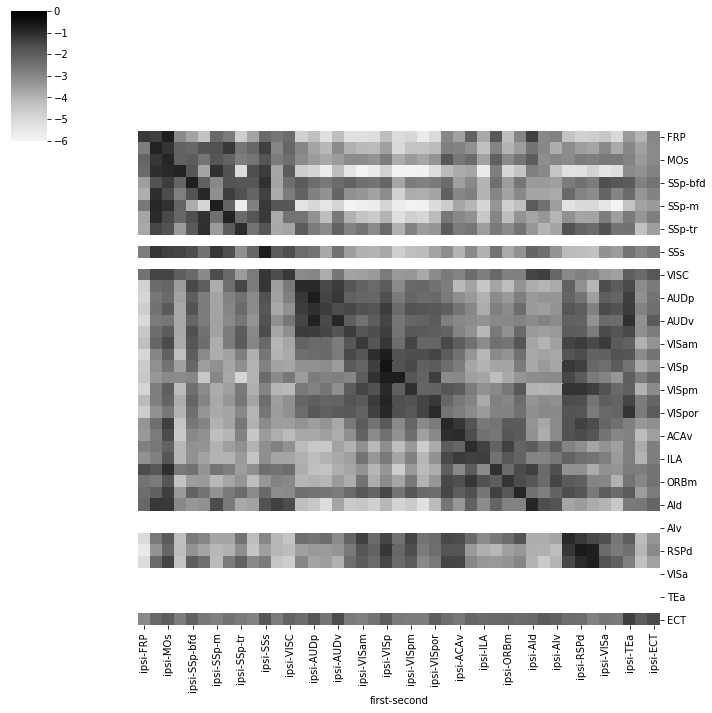

In [91]:
sns.clustermap(to_plot,
               vmin = -6,
               vmax=  0,
              col_cluster = False, 
               row_cluster = False,
              cmap = new_cmap)